# LASSO 问题的次梯度解法

对于 LASSO 问题
$$
\displaystyle \min_x \frac{1}{2}\|Ax-b\|_2^2 + \mu \|x\|_1.
$$
<p>不采用连续化策略，直接对原始的正则化系数利用次梯度法求解。</p>
注意到$\mathrm{sign}(x)\in\partial\|x\|_1$, 则次梯度的下降方向取为：
$d^k=-\left(A^\top (Ax-b)+\mu\cdot\mathrm{sign}(x)\right)$

In [1]:
def set_step(k, opts):
    type_ = opts['step_type']
    if type_ == 'fixed':
        a = opts['alpha0']
    elif type_ == 'diminishing':
        a = opts['alpha0'] / np.sqrt(k)
    elif type_ == 'diminishing2':
        a = opts['alpha0'] / k
    else:
        print('unsupported type.')
    return a

opt = {'maxit': 2000, 'ftol': 0, 'step_type': 'fixed', 
       'alpha0': 0.01, 'thres': 1e-4}
def l1_subgrad(x0, A, b, mu, opts):
    for i in opt.keys():
        if opts.get(i, -1) == -1:
            opts[i] = opt[i]
    x = x0
    out = {'f_hist': np.zeros((opts['maxit'])), 
           'f_hist_best': np.zeros((opts['maxit'])), 
           'g_hist': np.zeros((opts['maxit']))}
    f_best = np.inf
    for k in range(1, opts['maxit']):
        r = np.matmul(A, x) - b
        g = np.matmul(A.T, r)
        out['g_hist'][k] = np.linalg.norm(r, 2)
        f_now = 0.5 * np.linalg.norm(r, 2) ** 2 + mu * np.linalg.norm(x, 1)
        out['f_hist'][k] = f_now
        f_best = min(f_best, f_now)
        out['f_hist_best'][k] = f_best
        if k > 1 and abs(out['f_hist_best'][k] - out['f_hist_best'][k-1]) / abs(out['f_hist_best'][1]) < opts['ftol']:
            break
        x[abs(x) < opts['thres']] = 0
        sub_g = g + mu * np.sign(x)
        alpha = set_step(k, opts)
        x = x - alpha * sub_g
    out['itr'] = k
    out['f_hist'] = out['f_hist'][1:k]
    out['f_hist_best'] = out['f_hist_best'][1:k]
    out['g_hist'] = out['g_hist'][1:k]
    return [x, out]

## 次梯度法解LASSO问题

In [2]:
import random
import numpy as np
import scipy.sparse
random.seed(2)
m = 512
n = 1024
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.1).toarray()
b = np.matmul(A, u)

mu = 1
x0 = u + 1e-1 * np.random.randn(n, 1)

opts_g = {'maxit': 50000, 'alpha0': 1e-6, 'step_type': 'fixed'}
[x_g, out_g] = l1_subgrad(u, A, b, mu, opts_g)
f_star = out_g['f_hist_best'][-1]

# 步长 0.0005 进行实验
opts = {'maxit': 3000, 'alpha0': 0.0005, 'step_type': 'fixed'}
[x, out] = l1_subgrad(x0, A, b, mu, opts)
data1 = (np.array(out['f_hist']) - f_star) / f_star
data1_best = (np.array(out['f_hist_best']) - f_star) / f_star

# 步长 0.0002 进行实验
opts['alpha0'] = 0.0002
[x, out] = l1_subgrad(x0, A, b, mu, opts)
data2 = (np.array(out['f_hist']) - f_star) / f_star
data2_best = (np.array(out['f_hist_best']) - f_star) / f_star

# 步长 0.0001 进行实验
opts['alpha0'] = 0.0001
[x, out] = l1_subgrad(x0, A, b, mu, opts)
data3 = (np.array(out['f_hist']) - f_star) / f_star
data3_best = (np.array(out['f_hist_best']) - f_star) / f_star

# 取步长 0.002 开始的消失步长 0.002 / $\sqrt{k}$ 进行实验
opts['step_type'] = 'diminishing'
opts['alpha0'] = 0.002
[x, out] = l1_subgrad(x0, A, b, mu, opts)
data4 = (np.array(out['f_hist']) - f_star) / f_star
data4_best = (np.array(out['f_hist_best']) - f_star) / f_star

In [3]:
data1[:5], data2[:5], data3[:5], data4[:5]

(array([62.36002054, 12.92002077,  6.28296848,  4.05203974,  3.00778554]),
 array([62.36002054, 32.06563073, 19.32989196, 13.06555322,  9.56702276]),
 array([62.36002054, 45.46080584, 34.17705833, 26.44320211, 21.00187296]),
 array([   62.36002054,   390.50427808,  1991.54208198,  7293.80725292,
        19865.45837127]))

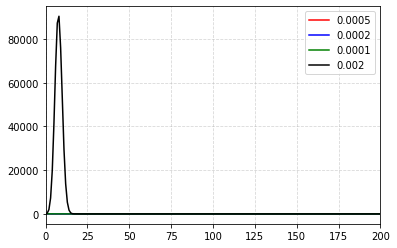

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.grid(True,linestyle='--',alpha=0.5)
plt.xlim(0,200)
plt.plot(list(range(len(data1))), data1, c = 'red', label='0.0005')
plt.plot(list(range(len(data2))), data2, c = 'blue', label='0.0002')
plt.plot(list(range(len(data3))), data3, c = 'green', label='0.0001')
plt.plot(list(range(len(data4))), data4, c = 'black', label='0.002')
plt.legend(loc='upper right')
plt.savefig('次梯度法1.png')

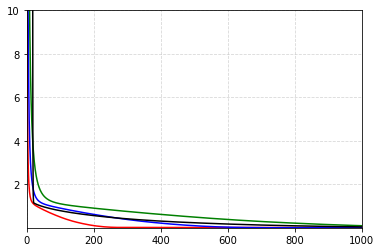

In [5]:
plt.grid(True,linestyle='--',alpha=0.5)
plt.ylim(1e-5, 10)
plt.xlim(0, 1000)
plt.plot(list(range(len(data1_best))), data1_best, c = 'red')
plt.plot(list(range(len(data2_best))), data2_best, c = 'blue')
plt.plot(list(range(len(data3_best))), data3_best, c = 'green')
plt.plot(list(range(len(data4_best))), data4_best, c = 'black')

## LASSO 问题的连续化次梯度法


利用连续化策略下的次梯度法进行求解。 该算法被外层连续化策略调用，完成某一固定正则化系数的内层迭代优化。
<p>对于目标函数，选定其次梯度为$\displaystyle A^\top (Ax-b)+\mu\cdot \mathrm{sign}(x)$， 并以次梯度方向作为下降方向进行迭代</p>

In [6]:
import time
import numpy as np
optsh = {'maxit': 200, 'ftol': 1e-8, 'gtol': 1e-6, 'alpha0': 0.01, 
           'sigma': 0.1, 'verbose': 0}
def LASSO_grad_huber_inn(x, A, b, mu, mu0, opt):
    for i in optsh.keys():
        if opt.get(i, -1) == -1:
            opt[i] = optsh[i]
    tic = time.time()
    r = np.matmul(A, x) - b
    g = np.matmul(A.T, r)
    huber_g = np.sign(x)
    idx = abs(x) < opt['sigma']
    huber_g[idx] = x[idx] / opt['sigma']
    
    g = g + mu * huber_g
    nrmG= np.linalg.norm(g, 2)
    
    f = 0.5 * np.linalg.norm(r, 2) ** 2 + \
                mu * (np.sum(np.square(x[idx])/(2 * opt['sigma'])) \
                      + np.sum(np.abs(x[abs(x) >= opt['sigma']]) - \
                               opt['sigma'] / 2))
    out = {}
    
    out['fvec'] = 0.5 * np.linalg.norm(r, 2) ** 2 + mu0 * np.linalg.norm(x, 1)
    alpha = opt['alpha0']
    eta = 0.2
    
    rhols = 1e-6
    gamma = 0.85
    Q = 1
    Cval = f
    for k in range(opt['maxit']):
        fp = f
        gp = g
        xp = x
        nls = 1
        while 1:
            x = xp - alpha * gp
            r = np.dot(A, x) - b
            g = np.dot(A.T, r)
            huber_g = np.sign(x)
            idx = abs(x) < opt['sigma']
            huber_g[idx] = x[idx] / opt['sigma']
            f = 0.5 * np.linalg.norm(r, 2) ** 2 + \
                mu * (np.sum(x[abs(x) >= opt['sigma']] - opt['sigma'] / 2))
            g = g + mu * huber_g
            if f <= Cval - alpha * rhols * nrmG ** 2 or nls >= 10:
                break
            alpha = eta * alpha 
            nls += 1
        nrmG = np.linalg.norm(g, 2)
        forg = 0.5 * np.linalg.norm(r, 2) ** 2 + mu0 * np.linalg.norm(x, 1)
        out['fvec'] = [out['fvec'], forg]
        if opt['verbose']:
            print('%4d\t %.4e \t %.1e \t %.2e \t %2d \n'%(k, f, nrmG, alpha, nls))
        if nrmG < opt['gtol'] or abs(fp - f) < opt['ftol']:
            break
        dx = x - xp
        dg = g - gp
        dxg = abs(np.matmul(dx.T, dx))
        if dxg > 0:
            if k % 2 == 0:
                alpha = np.matmul(dx.T, dx) / dxg
            else:
                alpha = dxg / np.matmul(dg.T, dg)
            alpha = max(min(alpha, 1e12), 1e-12)
        Qp = Q
        Q = gamma * Qp + 1
        Cval = (gamma * Qp * Cval + f) / Q
    out['flag'] = k == opt['maxit']
    out['fval'] = f
    out['itr'] = k
    out['tt'] = time.time() - tic
    out['nrmG'] = nrmG
    return [x, out]

optsp = {'maxit': 30, 'maxit_inn':1, 'ftol': 1e-8, 'gtol': 1e-6, 
        'factor': 0.1, 'verbose': 1, 'mul': 100, 'opts1':{},
        'etaf': 1e-1, 'etag': 1e-1}
optsp['gtol_init_ratio'] = 1 / optsp['gtol']
optsp['ftol_init_ratio'] = 1e5
def prox(x, mu):
    y = np.max(np.abs(x) - mu, 0)
    y = np.dot(np.sign(x), y)
    return y
def Func(A, b, mu0, x):
    w = np.dot(A, x) - b
    f = 0.5 * (np.matmul(w.T, w)) + mu0 * np.linalg.norm(x, 1)
    return f
def LASSO_con(x0, A, b, mu0, opts):
    L = max(np.linalg.eig(np.matmul(A.T, A))[0])
    for i in optsp.keys():
        if opts.get(i, -1) == -1:
            opts[i] = optsp[i]
    if not opts['alpha0']: opts['alpha0'] = 1 / L
    out = {}
    out['fvec'] = []
    k = 0
    x = x0
    mu_t = opts['mul']
    tic = time.time()
    f = Func(A, b, mu_t, x)
    opts1 = opts['opts1']
    opts1['ftol'] = opts['ftol'] * opts['ftol_init_ratio']
    opts1['gtol'] = opts['gtol'] * opts['gtol_init_ratio']
    out['itr_inn'] = 0
    while k < opts['maxit']:
        opts1['maxit'] = opts['maxit_inn']
        opts1['gtol'] = max(opts1['gtol'] * opts['etag'], opts['gtol'])
        opts1['ftol'] = max(opts1['ftol'] * opts['etaf'], opts['ftol'])
        opts1['verbose'] = opts['verbose'] > 1
        opts1['alpha0'] = opts['alpha0']
        if opts['method'] == 'grad_huber':
            opts1['sigma'] = 1e-3 * mu_t
        fp = f
        [x, out1] = LASSO_grad_huber_inn(x, A, b, mu_t, mu0, opts1)
        f = out1['fvec'][-1]
        out['fvec'].extend(out1['fvec'])# = [out['fvec'], out1['fvec']]
        k += 1
        nrmG = np.linalg.norm(x - prox(x - np.matmul(A.T, (np.matmul(A, x) - b)), mu0),2)
        if opts['verbose']:
            print('itr: %d\tmu_t: %e\titr_inn: %d\tfval: %e\tnrmG: %.1e\n'%(k, mu_t, out1.itr, f, nrmG))
        if not out1['flag']:
            mu_t = max(mu_t * opts['factor'], mu0)
        if mu_t == mu0 and (nrmG < opts['gtol'] or abs(f - fp) < opts['ftol']):
            break
        out['itr_inn'] = out['itr_inn'] + out1['itr']
    out['fval'] = f
    out['tt'] = time.time() - tic
    out['itr'] = k
    return [x, out]

In [7]:
import time
def set_step(k, opts):
    type_ = opts['step_type']
    if type_ == 'fixed':
        a = opts['alpha0']
    elif type_ == 'diminishing':
        a = opts['alpha0'] / np.sqrt(max(k, 100) - 99)
    elif type_ == 'diminishing2':
        a = opts['alpha0'] / (max(k, 100) - 99)
    else:
        print('unsupported type')
    return a
opt = {'maxit': 500, 'thres': 1e-4, 'step_type': 'fixed', 
       'alpha0': 0.01, 'ftol': 1e-12}
def LASSO_subgrad_inn(x, A, b, mu, mu0, opts):
    for i in opt.keys():
        if opts.get(i, -1) == -1:
            opts[i] = opt[i]
    if mu > mu0:
        opts['step_type'] = 'fixed'
    else:
        opts['step_type'] = opts['step_type']
    tic = time.time()
    out = {}
    out['fvec'] = []
    out['f_hist'] = [0] * opts['maxit']
    out['f_hist_best'] = [0] * opts['maxit']
    r = np.matmul(A ,x) - b
    gx = np.matmul(A.T, r)
    sub_g = gx + mu * np.sign(x)
    f_best = np.inf
    k = 1
    while k < opts['maxit']:
        alpha0 = set_step(k, opts)
        x = x - alpha * sub_g
        r = np.matmul(A, x) - b
        g = np.matmul(A.T, r)
        # 将x中小于某个设定阈值的值置为0. 这是由于绝对值较小的值虽然与0接近，但次梯度却与0相差较大
        x[np.abs(x) < opts['thres']] = 0
        sub_g = g + mu * np.sign(x)
        # 记录梯度范数，和x对应目标函数的值，以及目标函数历史值。
        out['grad_hist'][k] = np.linalg.norm(r, 2)
        tmp = 0.5 * np.square(np.linalg.norm(r, 2))
        nrmx1 = np.linalg.norm(x, 1)
        f = tmp + mu * nrmx1
        
        out['f_hist'][k] = f
        f_best = min(f_best, f)
        out['f_hist_best'][k] = f_best
        out['fvec'].append(tmp + mu0 * nrmx1)
        
        if opts['verbose']:
            print('itr: %4d \t f: %.4e \t step: %.1e\n'%(k, f, alpha))
        FDiff = np.abs(out['f_hist'][k] - out['f_hist'][max(k-1, 1)]) / np.abs(out['f_hist_best'][1])
        BFDiff = np.abs(out['f_hist_best'][max(k - 8, 1)]) - min(out['f_hist_best'][max(k-7, 1): k])
        if (k > 1 and FDiff < opt['ftol']) or (k > 8 and BFDiff < opt['ftol']):
            break
        k += 1
    if k == opt['maxit']:
        out['flag'] = 1
    else:
        out['flag'] = 0

### 实例：连续化次梯度法解决LASSO问题

In [8]:
import random
import numpy as np
import scipy.sparse
random.seed(2)
m = 512
n = 1024 
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.1).toarray()
b = np.matmul(A, u)
x0 = np.random.randn(n, 1)
mu = 1e-3
AA = np.matmul(A.T, A)
L = max(np.linalg.eig(AA)[0])
opts = {'maxit': 5000, 'maxit_inn': 500, 'opts1':{'step_type':'diminishing'}, 
        'method':'subgrad', 'verbose': 0, 'alpha0': 1 / L, 'ftol': 1e-12, 
        'ftol0': 1e4, 'etag': 1}
[x, out] = LASSO_con(x0, A, b, mu, opts)
f_star = out['fvec'][-1]

opts['maxits'] = 3000
opts['maxit_inn'] = 200
opts['opts1']['step_type'] = 'diminishing'
opts['verbose'] = 0
opts['ftol'] = 1e-8
[x, out] = LASSO_con(x0, A, b, mu, opts)
data1 = (np.array(out['fvec']) - f_star) / f_star
k1 = len(data1)

mu = 1e-2
opts['maxit'] = 5000
opts['maxit_inn'] = 500
opts['opts1']['step_type'] = 'fixed'
opts['ftol'] = 1e-10
[x, out] = LASSO_con(x0, A, b, mu, opts)
f_star = out['fvec'][-1]

opts['maxit'] = 3000
opts['maxit_inn'] = 200
opts['ftol'] = 1e-8
opts['opts1']['step_type'] = 'fixed'
[x, out] = LASSO_con(x0, A, b, mu, opts)
data2 = (np.array(out['fvec']) - f_star) / f_star
k2 = len(len(data2))

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(k1)), np.max(data1,0))
plt.plot(list(range(k2)), np.max(data2,0))